# NFL Predictor Model

Hello!! Welcome to my jupyter notebook for milestone 3. In this notebook, I will go through cleaning the data and merging two datasets I plan to use, engineer per-game statistics the model will use, and then implement an ensemble model for some predictions.
  
  
    
Summary of updates:  
> Added weeks to dataset   
> Added avg season/rolling QBR/ Allowed QBR to the feature set  
> Hyperparameters tuned for XGBoost model (Removed, hurt model performance)   
> Added wins and win-streak (Removed, hurt model performance)   


## ABSTRACT

This project was created as both a personal interest project and a project for my Graduate Machine Learning Course at WPI. I used a stacking ensemble model consisting of XGBoost, Random Forest Classifier, and Logistic Regression base learners, with a Logistic Regression meta learner. Using the nflreadpy api, which allows open access to multiple high-feature datasets, I was able to get a 73% accuracy score on test sets with this ensemble model. This notebook goes over my feature analysis / feature engineering,

## Research Question

Current research question: Can I, using the nflreadpy dataset, reliably predict the outcomes of NFL games before they happen?



In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
import nflreadpy as nfl
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, StratifiedKFold
# Heads up! You probably will have to open up the terminal in colab and do pip install nflreadpy to get
# the dataset api

## Overview and Motivation

My primary motivation for this project was my love of both sports and machine learning. I find any machine learning problem related to sports to be super fun and interesting to tackle, as sports are notoriously unpredicatble. The NFL is no stranger to this volatility, and is part of the reason why I love the sport so much.

I set out on this project to see if I could complete a model that could at least beat Vegas consistently (65+% accuracy) with publically available data. I thought it would be very cool to get this working, especially with a future website I plan to make with multipe ML models for different sports.

## Data and Cleaning

The data in these datasets come cleaned up (for the most part) already, and the columns that aren't clean are not being used for this model, so not much to clean. The real challenge comes from merging. This took the most amount of hours to really learn how to do, I was very confused the whole time but eventually got it to work

The issue? The team stats dataset had two entries per game every week, one for the home and one for the away team. The home and away teams were not denoted by home and away in any way, so I essentially had to make a mask that included info about the team's home/away status and the corresponding game_id, then use that to merge the team_stats into the schedules dataset to get a giant dataset with team stats for both teams from each game.

First step: get the team_stats dataset to have game_ids

(p.s: I realized it would be best to add point diff here as a new feature, but added the point differential rolling and season avgs in the feature engineering section)

In [ ]:
schedules = nfl.load_schedules(seasons=[2000, 2024]).to_pandas()
team_stats = nfl.load_team_stats(seasons=[2000,2024]).to_pandas()

#only using until season 2024, as the schedules and stats datasets contain
# a varied amount of info for upcoming/recently completed games

keys = ['game_id','season','week','game_type','home_team', 'away_team', 'home_score', 'away_score']

schedulesWKeys = schedules[keys].drop_duplicates()

ids = [column for column in schedulesWKeys.columns if column not in ['home_team', 'away_team']]
map = schedulesWKeys.melt(id_vars=ids, value_vars=['home_team', 'away_team'], var_name='side', value_name='team')

map['home_away'] = map['side'].str.replace('_team','', regex=False)

left_keys = ['season', 'week', 'team']
right_keys = ['season', 'week', 'team']

new_ts = team_stats.merge(map, left_on=left_keys, right_on=right_keys, how='inner')

# essentially just check if the team is home or away and put the points for or against in the correct column
new_ts['points_for'] = np.where(new_ts['home_away'].eq('home'),
                                new_ts['home_score'], new_ts['away_score'])
new_ts['points_against'] = np.where(new_ts['home_away'].eq('home'),
                                    new_ts['away_score'], new_ts['home_score'])
new_ts['point_diff'] = new_ts['points_for'] - new_ts['points_against']


print(new_ts)


      season  week team season_type opponent_team  completions  attempts  \
0       2000     1  ARI         REG           NYG           28        49   
1       2000     1  ATL         REG            SF           16        31   
2       2000     1  BAL         REG           PIT           18        32   
3       2000     1  BUF         REG           TEN           13        26   
4       2000     1  CAR         REG           WAS           17        26   
...      ...   ...  ...         ...           ...          ...       ...   
1079    2024    21   KC        POST           BUF           18        26   
1080    2024    21  PHI        POST           WAS           20        28   
1081    2024    21  WAS        POST           PHI           30        49   
1082    2024    22   KC        POST           PHI           21        32   
1083    2024    22  PHI        POST            KC           17        23   

      passing_yards  passing_tds  passing_interceptions  ...  gwfg_distance  \
0       

### Feature Engineering

While doing my feature engineering, I realized it would actually be better to just do this before merging the dataset. The features I'm engineering are what the model will actually use when predicting games. These will be rolling averages, season averages, and previous game performances. Examples would be rolling passing yards (avg yards for past 3 games), season passing yards (avg passing yards per game for the season), and previous game passing yards. This is just one example. See all of the features I add in the cell below :)

Possible features to add for final submission: Season/Rolling QB Rating, ints thrown, etc

In [ ]:


new_ts = new_ts.sort_values(by=['season','team', 'week'])

#rolling pass yds pg
new_ts['rolling_pass_yds'] = new_ts.groupby('team')['passing_yards'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_pass_yds'] = new_ts.groupby(['season','team'])['rolling_pass_yds'].shift(1)

# rolling rush yards pg
new_ts['rolling_rush_yds'] = new_ts.groupby('team')['rushing_yards'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_rush_yds'] = new_ts.groupby(['season', 'team'])['rolling_rush_yds'].shift(1)

# rolling complt %

new_ts['comp_pct'] = new_ts['completions'] / new_ts['attempts']
new_ts['rolling_comp_pct'] = new_ts.groupby('team')['comp_pct'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_comp_pct'] = new_ts.groupby(['season','team'])['rolling_comp_pct'].shift(1)

# rolling turnover differential (Takeaways - giveaways)

new_ts['turnover_diff'] = (new_ts['fumble_recovery_opp'] + new_ts['def_interceptions']) - (new_ts['passing_interceptions'] + new_ts['receiving_fumbles_lost'] +
                           new_ts['rushing_fumbles_lost'] + new_ts['sack_fumbles_lost'])
new_ts['rolling_turn_diff'] = new_ts.groupby('team')['turnover_diff'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_turn_diff'] = new_ts.groupby(['season','team'])['rolling_turn_diff'].shift(1)
new_ts['rolling_passing_cpoe'] = new_ts.groupby('team')['passing_cpoe'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_passing_cpoe'] = new_ts.groupby(['season','team'])['rolling_passing_cpoe'].shift(1)

# rolling yards per carry

new_ts['yards_per_carry'] = new_ts['rushing_yards'] / new_ts['carries']
new_ts['rolling_yards_per_carry'] = new_ts.groupby('team')['yards_per_carry'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_yards_per_carry'] = new_ts.groupby(['season','team'])['rolling_yards_per_carry'].shift(1)

# rolling pressure rate

new_ts['def_pressures'] = new_ts['def_qb_hits'] + new_ts['def_sacks']
new_ts['rolling_def_pressures'] = new_ts.groupby('team')['def_pressures'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_def_pressures'] = new_ts.groupby(['season','team'])['rolling_def_pressures'].shift(1)

# rolling interceptions

new_ts['rolling_interceptions'] = new_ts.groupby('team')['def_interceptions'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_interceptions'] = new_ts.groupby(['season','team'])['rolling_interceptions'].shift(1)

# rolling point differential

new_ts['rolling_point_diff'] = new_ts.groupby('team')['point_diff'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_point_diff'] = new_ts.groupby(['season','team'])['rolling_point_diff'].shift(1)

# season to date complt %

new_ts['season_comp_pct'] = new_ts.groupby(['season','team'])['comp_pct'].transform(lambda s: s.shift(1).expanding().mean())
# season pass yards pg

new_ts['season_pass_yd_pg'] = new_ts.groupby(['season','team'])['passing_yards'].transform(lambda s: s.shift(1).expanding().mean())
# season rush yards pg

new_ts['season_rush_yd_pg'] = new_ts.groupby(['season','team'])['rushing_yards'].transform(lambda s: s.shift(1).expanding().mean())
# season rush yards per carry per game

new_ts['season_yards_pc_pg'] = new_ts.groupby(['season','team'])['yards_per_carry'].transform(lambda s: s.shift(1).expanding().mean())
# season turnover differential pg

new_ts['season_turnover_diff_pg'] = new_ts.groupby(['season','team'])['turnover_diff'].transform(lambda s: s.shift(1).expanding().mean())

# season pressure rate pg

new_ts['season_pressure_pg'] = new_ts.groupby(['season','team'])['def_pressures'].transform(lambda s: s.shift(1).expanding().mean())

# season interceptions

new_ts['season_interceptions'] = new_ts.groupby(['season','team'])['def_interceptions'].transform(lambda s: s.shift(1).expanding().sum())

# season interceptions pg

new_ts['season_interceptions_pg'] = new_ts.groupby(['season','team'])['def_interceptions'].transform(lambda s: s.shift(1).expanding().mean())

# season point differential

new_ts['season_point_diff_pg'] = new_ts.groupby(['season','team'])['point_diff'].transform(lambda s: s.shift(1).expanding().mean())

# season epa

new_ts['season_passing_epa_pg'] = new_ts.groupby(['season','team'])['passing_epa'].transform(lambda s: s.shift(1).expanding().mean())
new_ts['season_rushing_epa_pg'] = new_ts.groupby(['season','team'])['rushing_epa'].transform(lambda s: s.shift(1).expanding().mean())

# season avg cpoe
new_ts['season_passing_cpoe'] = new_ts.groupby(['season','team'])['passing_cpoe'].transform(lambda s: s.shift(1).expanding().mean())


# QBR
completions = new_ts['completions']
att = new_ts['attempts']
yds = new_ts['passing_yards']
td  = new_ts['passing_tds']
inte = new_ts['passing_interceptions']

a = ((completions / att) - 0.3) * 5
b = ((yds / att) - 3) * 0.25
c = (td / att) * 20
d = 2.375 - (inte / att) * 25

# clip to [0, 2.375]
a = a.clip(0, 2.375)
b = b.clip(0, 2.375)
c = c.clip(0, 2.375)
d = d.clip(0, 2.375)

new_ts['QBR'] = ((a + b + c + d) / 6) * 100

# Allowed QBR

opp_qbr = (
    new_ts[['game_id', 'team', 'QBR']]
    .rename(columns={'team': 'opponent_team', 'QBR': 'Allowed_QBR'})
)

# merge opponent QBR onto each row by game + opponent_team
new_ts = new_ts.merge(
    opp_qbr,
    on=['game_id', 'opponent_team'],
    how='left'
)

#seasonal averages
new_ts['season_QBR'] = new_ts.groupby(['season','team'])['QBR'].transform(lambda s: s.shift(1).expanding().mean())
new_ts['season_Allowed_QBR'] = new_ts.groupby(['season','team'])['Allowed_QBR'].transform(lambda s: s.shift(1).expanding().mean())

#rolling QBR and QBR Allowed
new_ts['rolling_QBR'] = new_ts.groupby('team')['QBR'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_Allowed_QBR'] = new_ts.groupby('team')['Allowed_QBR'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
new_ts['rolling_QBR'] = new_ts.groupby(['season','team'])['rolling_QBR'].shift(1)
new_ts['rolling_Allowed_QBR'] = new_ts.groupby(['season','team'])['rolling_Allowed_QBR'].shift(1)


display(new_ts)

,season,week,team,season_type,opponent_team,completions,attempts,passing_yards,passing_tds,passing_interceptions,...,season_point_diff_pg,season_passing_epa_pg,season_rushing_epa_pg,season_passing_cpoe,QBR,Allowed_QBR,season_QBR,season_Allowed_QBR,rolling_QBR,rolling_Allowed_QBR
0,2000,1,ARI,REG,NYG,28,49,318,2,3,...,NaN,NaN,NaN,NaN,64.838435,70.750000,NaN,NaN,NaN,NaN
1,2000,2,ARI,REG,DAL,18,24,243,2,0,...,-5.000000,1.011349,-6.913380,NaN,134.548611,120.098039,64.838435,70.750000,64.838435,70.750000
2,2000,4,ARI,REG,GB,21,43,189,0,4,...,-2.000000,7.772372,-8.161313,NaN,22.335271,96.875000,99.693523,95.424020,99.693523,95.424020
3,2000,5,ARI,REG,SF,24,41,239,1,0,...,-10.000000,1.308791,-6.890520,NaN,83.282520,95.517677,73.907439,95.907680,73.907439,95.907680
4,2000,6,ARI,REG,CLE,17,30,171,2,0,...,-9.250000,1.485293,-5.268919,NaN,95.277778,88.825758,76.251210,95.810179,80.055468,104.163572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,2024,17,WAS,REG,ATL,24,36,227,3,1,...,5.600000,5.055170,3.330938,5.602318,100.115741,71.488095,102.297005,94.609889,110.805303,75.611158
1080,2024,18,WAS,REG,DAL,21,31,199,2,0,...,5.625000,5.049962,3.864155,5.232107,106.787634,81.004902,102.160676,93.164777,105.936476,71.268601
1081,2024,19,WAS,POST,TB,24,35,268,2,0,...,5.529412,4.664185,3.977637,5.214621,110.178571,146.527778,102.432850,92.449490,102.016225,73.053221
1082,2024,20,WAS,POST,DET,22,31,299,2,0,...,5.388889,5.020471,3.515151,5.497032,122.916667,52.083333,102.863168,95.453839,105.693982,99.673592


## THE MERGE

To merge, I essentially have to get the data to have multi-indexes and then unstack them. For example the wide dataframe has a home and away "sub-column" per column. So a stat for passing yards has a home passing yards and away passing yards column before setting the column to be "home_passing_yards" and "away_passing_yards" with the for loop when redeclaring wide.columns

In [ ]:
identifiers = {'season', 'week', 'team', 'home_away', 'game_id', 'home_team', 'away_team'}

stat_cols = [col for col in new_ts.columns if col not in identifiers and pd.api.types.is_numeric_dtype(new_ts[col])]


wide = new_ts.set_index(['game_id', 'home_away'])[stat_cols].unstack('home_away')
#now just set tthe columns back to normal so the dataset will actually be correctly assigning home and away yds
#instead of each column having 2 indexes
print(wide)
wide.columns = [f"{side}_{col}" for col, side in zip(wide.columns.get_level_values(1), wide.columns.get_level_values(0))]

wide = wide.reset_index()
games = schedules.drop_duplicates('game_id').merge(wide, on='game_id')


                completions      attempts      passing_yards      passing_tds  \
home_away              away home     away home          away home        away   
game_id                                                                         
2000_01_ARI_NYG          28   17       49   25           318  172           2   
2000_01_BAL_PIT          18   17       32   39           199  199           1   
2000_01_CAR_WAS          17   25       26   35           183  234           1   
2000_01_CHI_MIN          27   13       41   23           290  190           2   
2000_01_DEN_STL          19   25       29   35           307  441           2   
...                     ...  ...      ...  ...           ...  ...         ...   
2024_20_LA_PHI           26   15       44   20           324  128           2   
2024_20_WAS_DET          22   25       31   43           299  336           2   
2024_21_BUF_KC           22   18       34   26           237  245           2   
2024_21_WAS_PHI          30 

In [ ]:
games.fillna(0, inplace=True)
display(games)

/tmp/ipython-input-4174789908.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  games.fillna(0, inplace=True)


,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,Allowed_QBR_away,Allowed_QBR_home,season_QBR_away,season_QBR_home,season_Allowed_QBR_away,season_Allowed_QBR_home,rolling_QBR_away,rolling_QBR_home,rolling_Allowed_QBR_away,rolling_Allowed_QBR_home
0,2000_01_SF_ATL,2000,REG,1,2000-09-03,Sunday,13:00,SF,28,ATL,...,102.083333,100.810185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2000_01_JAX_CLE,2000,REG,1,2000-09-03,Sunday,13:00,JAX,27,CLE,...,97.762346,107.598039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2000_01_IND_KC,2000,REG,1,2000-09-03,Sunday,13:00,IND,27,KC,...,68.750000,92.317708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2000_01_CHI_MIN,2000,REG,1,2000-09-03,Sunday,13:00,CHI,27,MIN,...,65.489130,102.693089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2000_01_TB_NE,2000,REG,1,2000-09-03,Sunday,13:00,TB,21,NE,...,89.262821,86.631944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,2024_20_LA_PHI,2024,DIV,20,2025-01-19,Sunday,15:00,LA,22,PHI,...,91.250000,97.159091,95.505575,105.641572,98.036177,79.147015,95.211776,117.951213,97.411908,58.605451
538,2024_20_BAL_BUF,2024,DIV,20,2025-01-19,Sunday,18:30,BAL,25,BUF,...,86.742424,114.416667,120.445754,104.734337,90.998522,94.010414,121.733607,112.444196,77.319921,95.348103
539,2024_21_WAS_PHI,2024,CON,21,2025-01-26,Sunday,15:00,WAS,23,PHI,...,110.119048,75.042517,103.918616,104.884121,93.171181,80.095019,113.294291,101.072558,93.205338,73.630704
540,2024_21_BUF_KC,2024,CON,21,2025-01-26,Sunday,18:30,BUF,29,KC,...,111.858974,104.656863,103.787394,91.850734,95.084427,91.562006,99.443655,100.151961,106.099839,104.389812


## Making the Ensemble Model

Now that I have all the features I want, I'm going to make a new dataset with just the engineered features plus some extra features that are nice to have for game predictions (weather, days of rest for teams, etc). Then I will make the stacking model as outlined in scikit-learn's website:  

https://scikit-learn.org/stable/modules/ensemble.html#stacking

In [ ]:
featured_set = games[['result', 'week', 'away_rest', 'home_rest', 'away_moneyline', 'home_moneyline',
                     'wind','rolling_pass_yds_away', 'rolling_pass_yds_home', 'rolling_rush_yds_away',
                     'rolling_rush_yds_home', 'rolling_comp_pct_away', 'rolling_comp_pct_home',
                     'rolling_turn_diff_away', 'rolling_turn_diff_home', 'rolling_yards_per_carry_away',
                     'rolling_yards_per_carry_home', 'rolling_def_pressures_away', 'rolling_def_pressures_home',
                     'rolling_interceptions_away', 'rolling_interceptions_home', 'rolling_point_diff_away', 'rolling_point_diff_home',
                     'rolling_QBR_away', 'rolling_QBR_home', 'rolling_Allowed_QBR_away', 'rolling_Allowed_QBR_home', 'season_comp_pct_away', 'season_comp_pct_home', 'season_pass_yd_pg_home', 'season_pass_yd_pg_away',
                     'season_rush_yd_pg_away', 'season_rush_yd_pg_home', 'season_yards_pc_pg_away', 'season_yards_pc_pg_home',
                     'season_turnover_diff_pg_away', 'season_turnover_diff_pg_home', 'season_pressure_pg_away', 'season_pressure_pg_home',
                     'season_interceptions_away', 'season_interceptions_home', 'season_interceptions_pg_away', 'season_interceptions_pg_home',
                     'season_point_diff_pg_away', 'season_point_diff_pg_home', 'season_passing_epa_pg_away', 'season_passing_epa_pg_home',
                     'season_rushing_epa_pg_away', 'season_rushing_epa_pg_home', 'season_QBR_away', 'season_QBR_home', 'season_Allowed_QBR_away', 'season_Allowed_QBR_home']]

xgboost = XGBClassifier(n_estimators=800, max_depth=6, learning_rate=.05, objective='binary:logistic', eval_metric='logloss', random_state=42)

rf = RandomForestClassifier(n_estimators=800, random_state=42)

lr = LogisticRegressionCV(max_iter=1000)

estimators = [('xgb', xgboost),
              ('rf', rf),
              ('lr', lr)]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegressionCV(max_iter=1000), cv=5)

#target column for binary classification (1 for home win, 0 for away win)
featured_set['target'] = np.where(featured_set['result'] > 0, 1, 0)

X = featured_set.drop(columns=['result','target'])
y = featured_set['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

stack.fit(X_train, y_train)


/tmp/ipython-input-2313772352.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_set['target'] = np.where(featured_set['result'] > 0, 1, 0)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarn

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interac...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=800, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(n_estimators=800,
                                                       random_state=42)),
                               ('lr', LogisticRegressionCV(max_iter=1000))],
                   final_estimator=LogisticRegressionCV(max_iter=1000))

## Evaluation

Time to see the inital results of the model

In [ ]:
y_pred = stack.predict(X_test)
y_proba = stack.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("f1_score:", f1_score(y_test, y_pred))
print("auc:", roc_auc_score(y_test, y_pred))

Accuracy: 0.5963302752293578
f1_score: 0.6615384615384615
auc: 0.5828231292517008


At this point previously, I was getting .65 AUC and 66% accuracy. After adding Avg QBR allowed and AVG QBR, this dropped significantly, however, I believe this is because of playoff unpredictability. Let's see.

# Improving the model

I already went and changed the season's I'm evaluating to go back to 2000, which is as far back as the data I have goes reliably. This actually ended up making my accuracy, F1, and AUC worse, so I edited the model parameters and the results got better.

Next steps I think are hyperparameter tuning, extra feature engineering (win streaks? Turnover percentage?), and dropping playoff games from the stats. Playoff games are notoriously unpredictable and I think more than likely just add noise to the data.

In [ ]:
games = games[games['game_type'] == 'REG']



In [ ]:
featured_set = games[['result', 'week', 'away_rest', 'home_rest', 'away_moneyline', 'home_moneyline',
                     'wind','rolling_pass_yds_away', 'rolling_pass_yds_home', 'rolling_rush_yds_away',
                     'rolling_rush_yds_home', 'rolling_comp_pct_away', 'rolling_comp_pct_home',
                     'rolling_turn_diff_away', 'rolling_turn_diff_home', 'rolling_yards_per_carry_away',
                     'rolling_yards_per_carry_home', 'rolling_def_pressures_away', 'rolling_def_pressures_home',
                     'rolling_interceptions_away', 'rolling_interceptions_home', 'rolling_point_diff_away', 'rolling_point_diff_home',
                     'season_comp_pct_away', 'season_comp_pct_home', 'season_pass_yd_pg_home', 'season_pass_yd_pg_away',
                     'season_rush_yd_pg_away', 'season_rush_yd_pg_home', 'season_yards_pc_pg_away', 'season_yards_pc_pg_home',
                     'season_turnover_diff_pg_away', 'season_turnover_diff_pg_home', 'season_pressure_pg_away', 'season_pressure_pg_home',
                     'season_interceptions_away', 'season_interceptions_home', 'season_interceptions_pg_away', 'season_interceptions_pg_home',
                     'season_point_diff_pg_away', 'season_point_diff_pg_home', 'season_passing_epa_pg_away', 'season_passing_epa_pg_home',
                     'season_rushing_epa_pg_away', 'season_rushing_epa_pg_home', 'rolling_QBR_away', 'rolling_QBR_home', 'season_QBR_away', 'season_QBR_home',
                      'rolling_Allowed_QBR_away', 'rolling_Allowed_QBR_home', 'season_Allowed_QBR_away', 'season_Allowed_QBR_home']]

xgboost = XGBClassifier(n_estimators=800, max_depth=6, learning_rate=.05, objective='binary:logistic', eval_metric='logloss', random_state=42)

rf = RandomForestClassifier(n_estimators=800, random_state=42)

lr = LogisticRegressionCV(max_iter=1000)

estimators = [('xgb', xgboost),
              ('rf', rf),
              ('lr', lr)]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegressionCV(max_iter=1000), cv=5)

#target column for binary classification (1 for home win, 0 for away win)
featured_set['target'] = np.where(featured_set['result'] > 0, 1, 0)

X = featured_set.drop(columns=['result','target'])
y = featured_set['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

stack.fit(X_train, y_train)

/tmp/ipython-input-1247253159.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_set['target'] = np.where(featured_set['result'] > 0, 1, 0)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarn

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interac...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=800, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(n_estimators=800,
                                                       random_state=42)),
                               ('lr', LogisticRegressionCV(max_iter=1000))],
                   final_estimator=LogisticRegressionCV(max_iter=1000))

In [ ]:
y_pred = stack.predict(X_test)
y_proba = stack.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("f1_score:", f1_score(y_test, y_pred))
print("auc:", roc_auc_score(y_test, y_pred))

Accuracy: 0.7307692307692307
f1_score: 0.7741935483870968
auc: 0.7202380952380952


Previously, accuracy sat at about .67 and AUC at .66. This has now shot up by a solid 4 points from just adding the week (Week 1, Week 18, etc) to the dataset, and another 2 points after adding avg QBR and avg QBR allowed. This is really good news!

<Axes: title={'center': 'Meta-model weights'}>

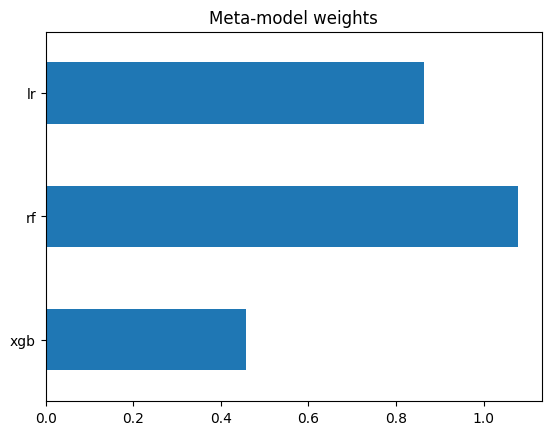

In [ ]:
meta = stack.final_estimator_

meta_weights = pd.Series(meta.coef_[0], index=stack.named_estimators_.keys())
meta_weights.plot(kind="barh", title="Meta-model weights")

NOTICE: Before adding weeks, the metalearner weighted XGBoost negatively, and RF was weighted extremely heavily (at about 3). Now after adding weeks, the models are weighted somewhat evenly, but the XGBoost model could obviously be better. Maybe doing some hyperparameter tuning could help, but I wanna do some more feature engineering.

==== XGB ====


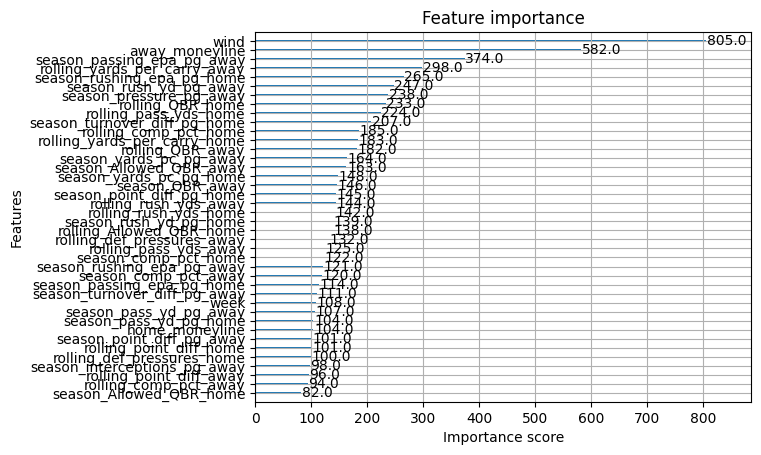

==== RF ====
away_moneyline: 0.0453
home_moneyline: 0.0449
wind: 0.0369
season_point_diff_pg_home: 0.0333
season_point_diff_pg_away: 0.0280
rolling_yards_per_carry_away: 0.0257
season_passing_epa_pg_away: 0.0251
season_rush_yd_pg_away: 0.0242
rolling_point_diff_away: 0.0229
season_rush_yd_pg_home: 0.0225
season_turnover_diff_pg_away: 0.0221
season_pressure_pg_away: 0.0220
season_rushing_epa_pg_away: 0.0218
season_comp_pct_away: 0.0216
rolling_rush_yds_away: 0.0216
rolling_yards_per_carry_home: 0.0211
rolling_point_diff_home: 0.0205
season_passing_epa_pg_home: 0.0205
season_yards_pc_pg_away: 0.0202
season_interceptions_pg_away: 0.0198
season_Allowed_QBR_away: 0.0194
season_QBR_away: 0.0188
rolling_QBR_home: 0.0185
season_rushing_epa_pg_home: 0.0181
season_Allowed_QBR_home: 0.0180
rolling_pass_yds_home: 0.0179
rolling_comp_pct_away: 0.0178
season_turnover_diff_pg_home: 0.0176
rolling_comp_pct_home: 0.0175
rolling_rush_yds_home: 0.0171


In [ ]:
import matplotlib.pyplot as plt

print('==== XGB ====')
xgb_trained = stack.named_estimators_['xgb']
xgb.plot_importance(xgb_trained, max_num_features=40)
plt.show()

print('==== RF ====')
rf_model = stack.named_estimators_['rf']

rf_importances = rf_model.feature_importances_
sorted_importances = sorted(zip(X_train.columns, rf_importances), key=lambda x: x[1], reverse=True)

for name, val in sorted_importances[:30]:
    print(f"{name}: {val:.4f}")

Ok! Our models agree pretty well on feature importance and seem relatively consistent. This is good.

## Hyperparameter Tuning

Alright, this model is working great, and I haven't even tuned the XGBoost model (which typically requires a lot of tuning).

After tuning hyperparameters, my model actually ended up dropping about 2 points in all 3 evaluation metrics. I decided to omit this section.

In [ ]:
'''param_distributions = {
    'n_estimators': [200, 400, 600, 800, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],

    'max_depth': [2, 3, 4, 5, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7, 10],
    'gamma': [0, 0.1, 0.2, 0.5, 1],
    'alpha': [0, 0.1, 0.5, 1, 5],
    'lambda': [0.1, 1, 5, 10],


    'subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.8, 1.0],


    'scale_pos_weight': [1, 2, 5, 10, 20],

    'grow_policy': ['depthwise', 'lossguide'],
    'max_leaves': [None, 8, 16, 32]
}

new_xgb = XGBClassifier()

random_search = RandomizedSearchCV(
    estimator=new_xgb,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best score: {best_score}")'''


'param_distributions = {\n    \'n_estimators\': [200, 400, 600, 800, 1000, 1500],\n    \'learning_rate\': [0.01, 0.03, 0.05, 0.1, 0.2],\n  \n    \'max_depth\': [2, 3, 4, 5, 6, 8, 10],\n    \'min_child_weight\': [1, 3, 5, 7, 10],\n    \'gamma\': [0, 0.1, 0.2, 0.5, 1],\n    \'alpha\': [0, 0.1, 0.5, 1, 5],\n    \'lambda\': [0.1, 1, 5, 10],\n    \n    \n    \'subsample\': [0.5, 0.7, 0.8, 0.9, 1.0],\n    \'colsample_bytree\': [0.3, 0.5, 0.7, 0.8, 1.0],\n  \n    \n    \'scale_pos_weight\': [1, 2, 5, 10, 20],\n    \n    \'grow_policy\': [\'depthwise\', \'lossguide\'],\n    \'max_leaves\': [None, 8, 16, 32]\n}\n\nnew_xgb = XGBClassifier()\n\nrandom_search = RandomizedSearchCV(\n    estimator=new_xgb,\n    param_distributions=param_distributions,\n    n_iter=50,\n    cv=5,\n    scoring=\'accuracy\',\n    random_state=42\n)\n\nrandom_search.fit(X_train, y_train)\n\nbest_model = random_search.best_estimator_\nbest_params = random_search.best_params_\nbest_score = random_search.best_score_\n\nprin

In [ ]:
'''xgb_tuned = random_search.best_estimator_

rf = RandomForestClassifier(n_estimators=800, random_state=42)

lr = LogisticRegressionCV(max_iter=1000)

estimators = [('xgb', xgb_tuned),
              ('rf', rf),
              ('lr', lr)]

new_stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegressionCV(max_iter=1000), cv=5)

#target column for binary classification (1 for home win, 0 for away win)
featured_set['target'] = np.where(featured_set['result'] > 0, 1, 0)

X = featured_set.drop(columns=['result','target'])
y = featured_set['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

new_stack.fit(X_train, y_train)'''

"xgb_tuned = random_search.best_estimator_\n\nrf = RandomForestClassifier(n_estimators=800, random_state=42)\n\nlr = LogisticRegressionCV(max_iter=1000)\n\nestimators = [('xgb', xgb_tuned),\n              ('rf', rf),\n              ('lr', lr)]\n\nnew_stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegressionCV(max_iter=1000), cv=5)\n\n#target column for binary classification (1 for home win, 0 for away win)\nfeatured_set['target'] = np.where(featured_set['result'] > 0, 1, 0)\n\nX = featured_set.drop(columns=['result','target'])\ny = featured_set['target']\n\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.2, random_state=42, stratify=y\n)\n\nnew_stack.fit(X_train, y_train)"

I'm going to make a table that tracks wins / season cumalitive wins for each team and then merge it back into the dataset

# FINAL EVALUATION

The final evalutation of my model will look at:  
- Performance against randomly guessing
- Performance against guessing only home team
- Performance against betting based only on the moneyline from Vegas  

Before showing a confusion matrix.

In [ ]:
y_pred = stack.predict(X_test)
y_proba = stack.predict_proba(X_test)[:, 1]

# For guessing only home team

y_home_only_pred = np.ones(len(y_test))

acc_home_only = (y_home_only_pred == y_test).mean()

# Guessing for only moneyline

home_ml = X_test['home_moneyline']
away_ml = X_test['away_moneyline']

favorite_pred = np.where(home_ml < away_ml, 1, 0)
acc_favorite = (favorite_pred == y_test).mean()

print(" === MY MODEL ===")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("f1_score: ", f1_score(y_test, y_pred))
print("auc: ", roc_auc_score(y_test, y_pred))

print()
print(" === OTHER MODELS ===")
print("Random Guessing will eventually converge to 50% accuracy")
print("Only betting on home team: ", acc_home_only)
print("Only betting on money line favorite: ", acc_favorite)

 === MY MODEL ===
Accuracy:  0.7307692307692307
f1_score:  0.7741935483870968
auc:  0.7202380952380952

 === OTHER MODELS ===
Random Guessing will eventually converge to 50% accuracy
Only betting on home team:  0.5384615384615384
Only betting on money line favorite:  0.6730769230769231


## Analysis compared to other models

This checks out when looking at known averages. Always betting with vegas will get you about 67-68% wins, only betting on the home team will get you a win a little over 50% of the time (home field advantage is very real), and truly random guessing will get you about 50% by law of probablity.  

This means my model is considerably better than randomly guessing or betting on the home team, and is notably better than betting on the moneyline favorite. Beating Vegas by 6 points is also great.

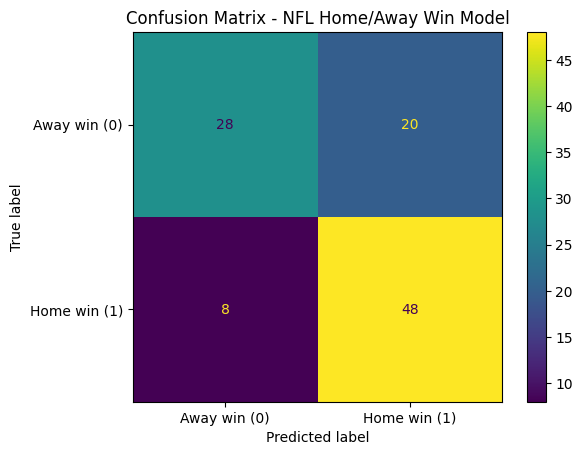

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Away win (0)', 'Home win (1)']
)

disp.plot(values_format='d')
plt.title("Confusion Matrix - NFL Home/Away Win Model")
plt.show()


## Confusion Matrix Analysis

This confusion matrix makes sense and is common in NFL models. Because home wins are more common, and have stronger predictive signals, so they are easier to predict. The accuracy of 50+% on away teams tells me that the model is still effectively predicting away teams, however is just weaker in this regard.

Most NFL prediction models tend to collapse towards only predicting home team wins, as home teams usually have stronger predictive signals. But >50% accuracy is a great sign when dealing with away teams, because it means my model is actually learning away team predictive signals that other models tend to miss.

# Final Evalutation and Future Plans

For the future, I plan to integrate this model into a website that predicts NFL games weekly. Maybe I'll expand the sports I can predict to baseball, basketball, or soccer.

I struggled to bring this model above 73% accuracy, and it seems any additions to the dataset I tried making actually caused worse performance. I'm excited to test this on real NFL games that haven't happened yet and will see how the models actually stack up for this week's upcoming games.

## Final Considerations

For this project, due to time constraints, I was unable to test other stacking configurations, like different models making up the base learners / meta learner, and did not consider other ML methods. From prior research, it seems stacking ensembles seem to be most effective for this.